<a href="https://colab.research.google.com/github/polarabbit/booksbot/blob/master/vix_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install yfinance ; pip install backtesting

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import skew
from scipy.stats import kurtosis
import datetime
from sklearn import linear_model
import math
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import asarray
from scipy.stats import pearsonr
import seaborn as sns
from datetime import date, timedelta, datetime
from dateutil import parser
from matplotlib import pyplot as plt
from sklearn.tree import export_text
from sklearn import tree, datasets
import jinja2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score, confusion_matrix
from backtesting import Backtest, Strategy
from backtesting.lib import crossover


/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [ ]:
vix_futures_csv = 'https://raw.githubusercontent.com/ayoubbensakhria/wqu690/master/data/vix_futures.csv'
vix_futures = pd.read_csv(vix_futures_csv, parse_dates=True)

In [ ]:
vix_futures.index = pd.to_datetime(vix_futures['Date']).dt.date

In [ ]:
vix_df=vix_futures.drop(columns=['Date']).iloc[:,0:6]

In [ ]:
vix_df=vix_df[::-1]

In [ ]:
vix_df.index=pd.to_datetime(vix_df.index)

In [ ]:
download = "^GSPC ^IXIC ^VIX"
df = yf.download(download, start = "1990-01-01", end = "2022-10-15")["Adj Close"]
df1 = yf.download("^GSPC ^IXIC ^VIX VXX VXZ", start = "2018-01-26", end = "2022-10-15")["Adj Close"]

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  5 of 5 completed


In [ ]:
df1["diff"]=df1["VXZ"]-df1["VXX"]

Text(0.5, 1.0, '^GSPC S&P500')

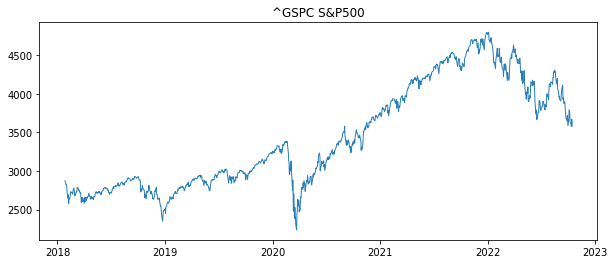

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(df1['^GSPC'], color = '#2980B9', linewidth = 1, label = 'S&P500')
plt.title("^GSPC S&P500")

Text(0.5, 1.0, 'VIX ')

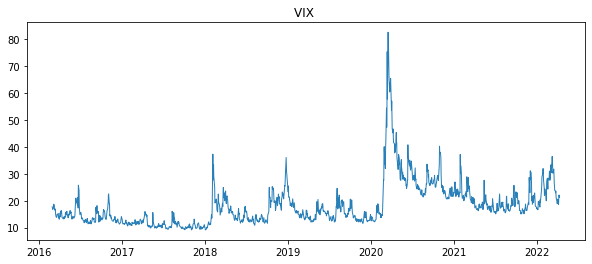

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(vix_df['VIX'], color = '#2980B9', linewidth = 1, label = 'VIX ')
plt.title("VIX ")

Text(0.5, 1.0, 'VIX Future M1')

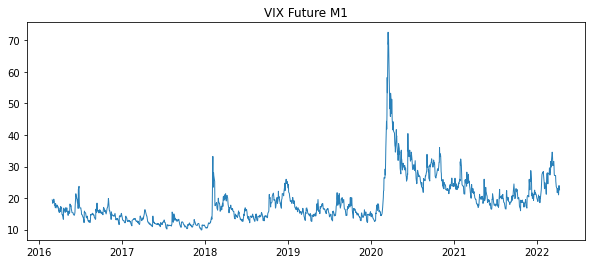

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(vix_df['M1'], color = '#2980B9', linewidth = 1, label = 'VIX Future M1')
plt.title("VIX Future M1")

Text(0.5, 1.0, 'VIX - M2')

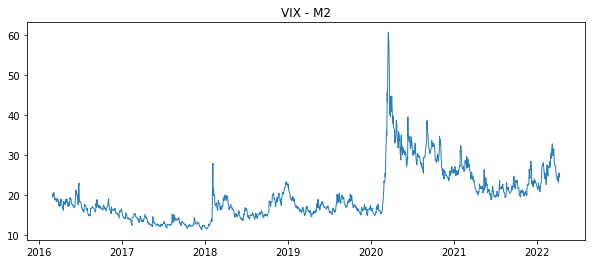

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(vix_df['M2'], color = '#2980B9', linewidth = 1, label = 'VIX - M2')
plt.title("VIX - M2")

In [ ]:
def perform_adf_test(series):
    result=adfuller(series)
    print ('ADF stats: %f' % result[0])
    print('p-value: %f' % result[1])

In [ ]:
#only VIX is stationary 
#only VIX is stationary 
perform_adf_test(df1.VXX),perform_adf_test(df1.VXZ),perform_adf_test(df1['^GSPC']),perform_adf_test(df1['^VIX']),
perform_adf_test(df1['diff'])

ADF stats: -1.590456
p-value: 0.488386
ADF stats: -1.754735
p-value: 0.403155
ADF stats: -1.456018
p-value: 0.555146
ADF stats: -3.841765
p-value: 0.002508
ADF stats: -1.396109
p-value: 0.584140


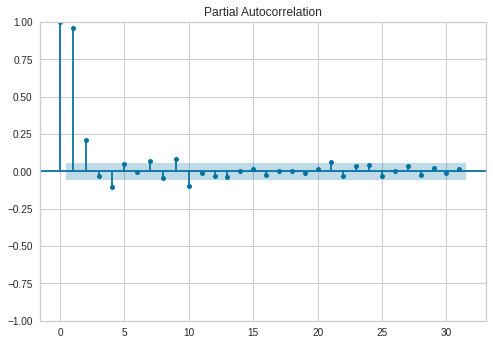

In [ ]:
pacf_plot= plot_pacf(df1['^VIX'])

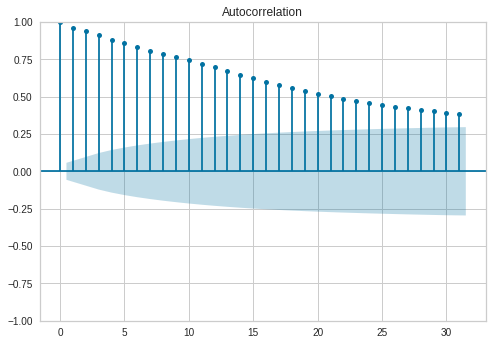

In [ ]:
acf_plot= plot_acf(df1['^VIX'])

In [ ]:
#ARMA model for VIX

In [ ]:
first_diffs_sp500=(df1['^GSPC']-df1['^GSPC'].shift(1)).dropna()

Text(0.5, 1.0, 'first_diffs_sp500')

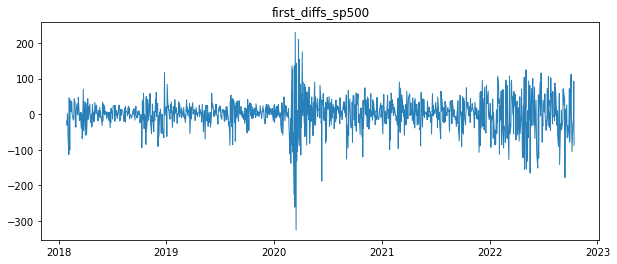

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(first_diffs_sp500, color = '#2980B9',linewidth = 1, label = 'first_diffs_sp500')
plt.title("first_diffs_sp500")

In [ ]:
#stationary first diff sp 500
perform_adf_test(first_diffs_sp500)

ADF stats: -10.912581
p-value: 0.000000


/root/.local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


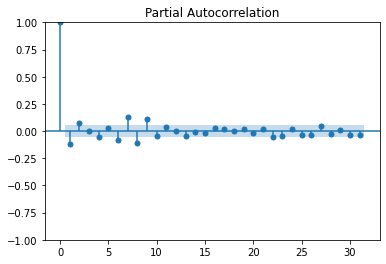

In [ ]:
pacf_plot= plot_pacf(first_diffs_sp500)

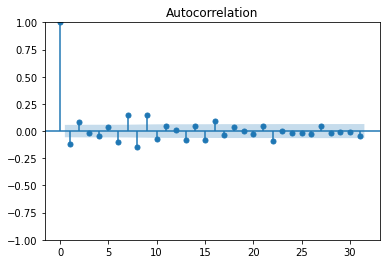

In [ ]:
acf_plot= plot_acf(first_diffs_sp500)

In [ ]:
#modeling SP500 first difference
model=ARMA(first_diffs_sp500,order=(1,0,1))



In [ ]:
model_fit=model.fit()

In [ ]:
prediction_info=model_fit.forecast(21)

predictions = prediction_info[0]
lower_bound = prediction_info[2][:,0]
upper_bound = prediction_info[2][:,1]

In [ ]:
predictions,lower_bound,upper_bound

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(first_diffs_sp500.reset_index().drop("Date",axis=1))
plt.plot(np.arange(len(first_diffs_sp500)+1,len(first_diffs_sp500)+22),predictions,color='g')
plt.fill_between(np.arange(len(first_diffs_sp500)+1,len(first_diffs_sp500)+22),lower_bound,upper_bound,color='g',alpha=0.1)

In [ ]:
def undo_transformations(predictions, series):
    first_pred = series.iloc[-1]+predictions[0]
    orig_predictions =[first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = orig_predictions[-1]+predictions[i+1]
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [ ]:
orig_predictions= undo_transformations(predictions,df1['^GSPC'] )
orig_lower_bound = undo_transformations(lower_bound, df1['^GSPC'])
orig_upper_bound = undo_transformations(upper_bound, df1['^GSPC'])

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df1['^GSPC'].reset_index().drop("Date",axis=1))
plt.plot(np.arange(len(df1['^GSPC'])+1,len(df1['^GSPC'])+22),orig_predictions,color='g')
plt.fill_between(np.arange(len(df1['^GSPC'])+1,len(df1['^GSPC'])+22),orig_lower_bound,orig_upper_bound,color='g',alpha=0.1)
plt.title('SP500')

In [ ]:
vix_df

,VIX,M1,M2,VIX3M,VXX,SPX
Date,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,22.70,1978.3500
2016-03-02,17.09,19.30,20.25,19.92,22.32,1986.4500
2016-03-03,16.70,18.35,19.50,19.49,21.58,1993.4000
2016-03-04,16.86,18.95,20.00,19.63,21.84,1999.9900
2016-03-07,17.35,18.60,19.80,19.90,21.90,2001.7600
...,...,...,...,...,...,...
2022-04-04,18.57,21.00,23.21,23.03,24.43,4582.6401
2022-04-05,21.03,22.85,24.55,24.90,24.81,4525.1201
2022-04-06,22.10,23.95,25.53,25.80,24.38,4481.1499


In [ ]:
vix_df['after_1m'] = vix_df['SPX'].shift(-21)
vix_df['after_1w'] = vix_df['SPX'].shift(-5)

In [ ]:
vix_df['rolling 1m return'] = (vix_df['after_1m']-vix_df['SPX'])/vix_df['SPX'] 
vix_df['rolling 1w return'] = (vix_df['after_1w']-vix_df['SPX'])/vix_df['SPX'] 

In [ ]:
vix_df['rolling 1m return'].describe(),vix_df['rolling 1w return'].describe()

(count    1519.000000
 mean        0.012106
 std         0.045058
 min        -0.329668
 25%        -0.004360
 50%         0.017670
 75%         0.034303
 max         0.251144
 Name: rolling 1m return, dtype: float64, count    1535.000000
 mean        0.002935
 std         0.022867
 min        -0.179666
 25%        -0.005569
 50%         0.004536
 75%         0.014059
 max         0.173974
 Name: rolling 1w return, dtype: float64)

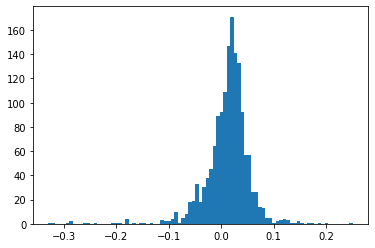

In [ ]:
plt.hist(vix_df['rolling 1m return'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
skew(vix_df['rolling 1m return'].dropna(), axis=0, bias=True),kurtosis(vix_df['rolling 1m return'].dropna(), axis=0, bias=True),skew(vix_df['rolling 1w return'].dropna(), axis=0, bias=True),kurtosis(vix_df['rolling 1w return'].dropna(), axis=0, bias=True)

(-1.859928220326088,
 12.279282722779598,
 -0.9843621181296841,
 10.949594436085409)

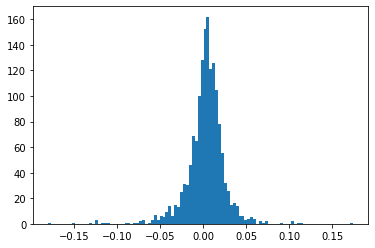

In [ ]:
plt.hist(vix_df['rolling 1w return'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
perform_adf_test(vix_df['rolling 1w return'].dropna()),perform_adf_test(vix_df['rolling 1m return'].dropna())

ADF stats: -8.786121
p-value: 0.000000
ADF stats: -5.550460
p-value: 0.000002


(None, None)

In [ ]:
vix_df["c0"]=vix_df["M1"]/vix_df["VIX"]-1
vix_df["c1"]=vix_df["M2"]/vix_df["M1"]-1
vix_df["c2"]=vix_df["VIX3M"]/vix_df["M2"]-1
vix_df["SP500 return"]=np.log(vix_df['SPX'])-np.log(vix_df['SPX']).shift(1)

In [ ]:
rho = vix_df.corr()
pval = vix_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
before_2020=vix_df[:'2020-1-1']
after_2020=vix_df['2020-1-1':]

In [ ]:
before_2020.shape,after_2020.shape

((967, 14), (573, 14))

In [ ]:
rho = before_2020.corr()
pval = before_2020.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
rho = after_2020.corr()
pval = after_2020.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
#label buy and sell signals
#1 buy, 0 hold, -1 sell, threshold +-1%
signal = []
for row in vix_df['rolling 1m return']:
    if row < -0.03 :    signal.append(-1)  
    elif row< 0.03: signal.append(0)
    else:           signal.append(1)

vix_df["signal"]=signal

In [ ]:
#label buy and sell signals
#1 buy, 0 hold, -1 sell, threshold +-1%
signal_weekly = []
for row in vix_df['rolling 1w return']:
    if row < -0.03 :    signal_weekly.append(-1)  
    elif row< 0.03: signal_weekly.append(0)
    else:           signal_weekly.append(1)

vix_df["signal_weekly"]=signal_weekly

In [ ]:
vix_df['rolling 1w return'].isna().sum(),vix_df['rolling 1m return'].isna().sum()

(5, 21)

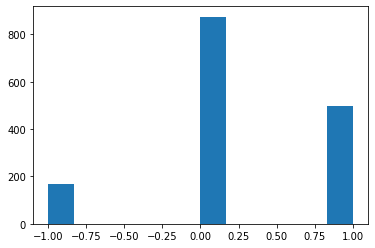

In [ ]:
#plot rolling returns distribution
plt.hist(vix_df['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

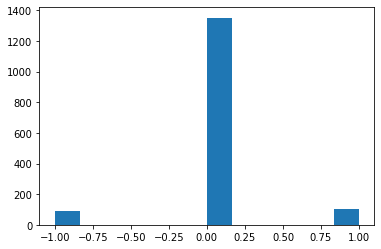

In [ ]:
#plot rolling returns distribution
plt.hist(vix_df['signal_weekly'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
#contangos
contangos_c0= vix_df.loc[vix_df['c0'] >0]
contangos_c1= vix_df.loc[vix_df['c1'] >0]
contangos_c2= vix_df.loc[vix_df['c2'] >0]
#backwardation
back_c0= vix_df.loc[vix_df['c0'] <=0]
back_c1= vix_df.loc[vix_df['c1'] <=0]
back_c2= vix_df.loc[vix_df['c2'] <=0]

In [ ]:
contangos_c0.shape,contangos_c1.shape,contangos_c2.shape,back_c0.shape,back_c1.shape,back_c2.shape

((1230, 15), (1303, 15), (936, 15), (310, 15), (237, 15), (604, 15))

In [ ]:
rho = contangos_c0.corr()
pval = contangos_c0.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
rho = contangos_c1.corr()
pval = contangos_c1.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
rho = contangos_c1.corr()
pval = contangos_c1.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
rho = back_c0.corr()
pval = back_c0.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
rho = back_c1.corr()
pval = back_c1.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
rho = back_c2.corr()
pval = back_c2.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

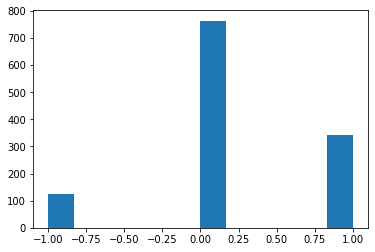

In [ ]:
#plot rolling returns distribution
plt.hist(contangos_c0['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

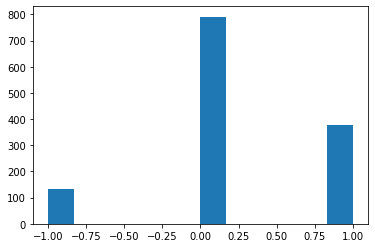

In [ ]:
#plot rolling returns distribution
plt.hist(contangos_c1['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

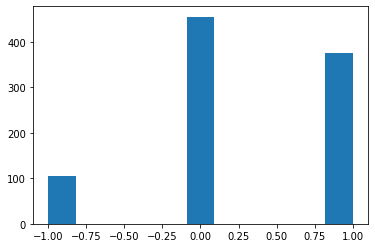

In [ ]:
#plot rolling returns distribution
plt.hist(contangos_c2['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

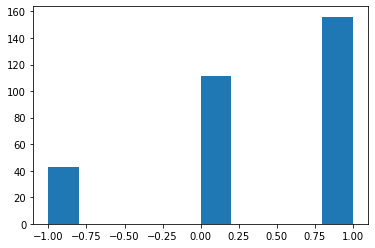

In [ ]:
#plot rolling returns distribution
plt.hist(back_c0['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

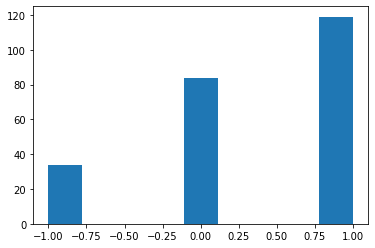

In [ ]:
#plot rolling returns distribution
plt.hist(back_c1['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

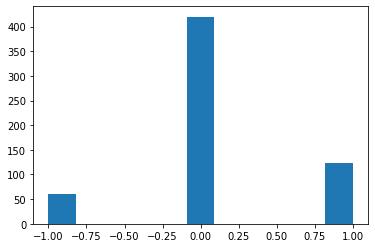

In [ ]:
#plot rolling returns distribution
plt.hist(back_c2['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
#stationary series
perform_adf_test(vix_df.c0),perform_adf_test(vix_df.c1),perform_adf_test(vix_df.c2),perform_adf_test(vix_df['rolling 1m return'].dropna())

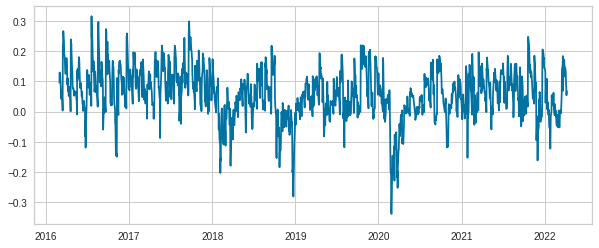

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(vix_df['c0'])

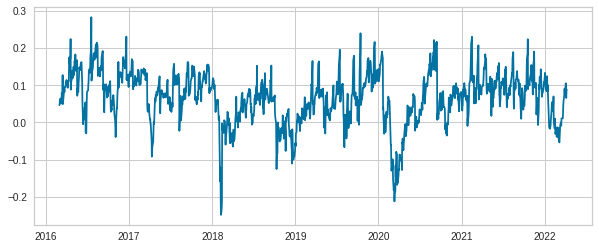

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(vix_df['c1'])

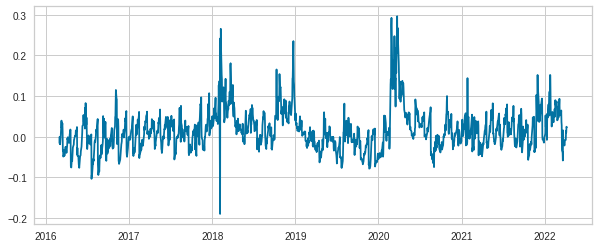

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(vix_df['c2'])

In [ ]:
vix_df=vix_df.dropna()
#LR1
X = vix_df[['VIX','c0','c1','c2','SPX']]
Y = vix_df['rolling 1m return']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
summary = model.summary()
print(summary)

In [ ]:
perform_adf_test(vix_df['VIX']),perform_adf_test(vix_df['M1']),perform_adf_test(vix_df['M2'])

ADF stats: -4.075563
p-value: 0.001063
ADF stats: -3.673579
p-value: 0.004501
ADF stats: -3.042524
p-value: 0.031110


(None, None, None)

In [ ]:
#first regression to determine the spread on spot vix next time period 
X = vix_df[['c0']][:-1]
y = vix_df['VIX'].shift(-1).dropna()
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     730.1
Date:                Mon, 17 Oct 2022   Prob (F-statistic):          6.73e-132
Time:                        10:11:30   Log-Likelihood:                -5140.8
No. Observations:                1539   AIC:                         1.029e+04
Df Residuals:                    1537   BIC:                         1.030e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.4924      0.213    100.750      0.0

In [ ]:
X = vix_df[['c0']][:-1]
y = (vix_df['VIX'].shift(-1)-vix_df['VIX']).dropna()
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     16.49
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           5.13e-05
Time:                        11:56:58   Log-Likelihood:                -3307.3
No. Observations:                1539   AIC:                             6619.
Df Residuals:                    1537   BIC:                             6629.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1496      0.065     -2.309      0.0

In [ ]:
#regression: to determine the spread on spot vix next time period 
spread= vix_df['M1']-vix_df['VIX']
X = spread[:-1]
y = (vix_df['VIX'].shift(-1)-vix_df['VIX']).dropna()
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     25.89
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           4.07e-07
Time:                        11:56:43   Log-Likelihood:                -3302.7
No. Observations:                1539   AIC:                             6609.
Df Residuals:                    1537   BIC:                             6620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0895      0.056     -1.605      0.1

In [ ]:
#regression: to determine the spread on spot vix next time period 
spread= vix_df['M1']-vix_df['VIX']
X = spread[:-1]
y = (vix_df['M1'].shift(-1)-vix_df['M1']).dropna()
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                     M1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3776
Date:                Mon, 17 Oct 2022   Prob (F-statistic):              0.539
Time:                        11:56:31   Log-Likelihood:                -2844.1
No. Observations:                1539   AIC:                             5692.
Df Residuals:                    1537   BIC:                             5703.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0103      0.041      0.249      0.8

In [ ]:
#regression: to determine the spread on spot vix next time period 
spread= vix_df['M1']-vix_df['VIX']
X = spread[:-1]
y = vix_df['VIX'].shift(-1).dropna()
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     900.8
Date:                Mon, 17 Oct 2022   Prob (F-statistic):          3.77e-156
Time:                        10:08:56   Log-Likelihood:                -5084.9
No. Observations:                1539   AIC:                         1.017e+04
Df Residuals:                    1537   BIC:                         1.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8898      0.178    112.018      0.0

In [ ]:
#regression 2 to determine the spread on future vix next time period 
spread= vix_df['M1']-vix_df['VIX']
X = spread[:-1]
y = vix_df['M1'].shift(-1).dropna()
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                     M1   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     442.8
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           1.36e-86
Time:                        10:09:54   Log-Likelihood:                -5030.9
No. Observations:                1539   AIC:                         1.007e+04
Df Residuals:                    1537   BIC:                         1.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9897      0.171    116.601      0.0

In [ ]:
acf_plot(vix_df['VIX'])

TypeError: ignored

In [ ]:
X = vix_df[['VIX','c0','c1','c2']]
y = vix_df['rolling 1m return']


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
regr = linear_model.LinearRegression()

# fit the model to the training data (learn the coefficients)
regr.fit(X_train, y_train)

In [ ]:
print(regr.intercept_)
print(regr.coef_)


In [ ]:
X_train.shape,X_test.shape

In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
from sklearn import metrics
#Mean Absolute Error (MAE) 
print(metrics.mean_absolute_error(y_test, y_pred))
#Mean Squared Error (MSE)
print(metrics.mean_squared_error(y_test, y_pred))
#Root Mean Squared Error (RMSE)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
est = sm.OLS(y_train, X_train)
est2 = est.fit()
print(est2.summary())

In [ ]:
#pip install --user pycaret-ts-alpha

In [ ]:
#compare models
from pycaret.classification import *
#s = setup(data=y_train, X_train, target= signal)

In [ ]:
train_data_0=vix_df.sample(frac=0.9,random_state=345)
test_data_0 = vix_df.drop(train_data_0.index)
train_data=train_data_0.drop(['rolling 1m return','after_1m','rolling 1w return','after_1w','signal_weekly','SP500 return','SPX'],axis=1)
test_data=test_data_0.drop(['rolling 1m return','after_1m','rolling 1w return','after_1w','signal_weekly','SP500 return','SPX'],axis=1)
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)


In [ ]:
from pycaret.classification import *

In [ ]:
s=setup(data=train_data,target='signal',session_id=	345)

In [ ]:
#compare models
model= compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7784,0.8807,0.7019,0.7794,0.7736,0.5892,0.5938,0.295
lightgbm,Light Gradient Boosting Machine,0.7629,0.8701,0.6950,0.7638,0.7600,0.5657,0.5687,0.364
rf,Random Forest Classifier,0.7474,0.8622,0.6353,0.7459,0.7371,0.5225,0.5305,0.369
knn,K Neighbors Classifier,0.7258,0.8385,0.6611,0.7287,0.7244,0.5039,0.5065,0.132
dt,Decision Tree Classifier,0.7227,0.7506,0.6665,0.7267,0.7219,0.5040,0.5064,0.036
gbc,Gradient Boosting Classifier,0.7113,0.8335,0.5870,0.7081,0.6986,0.4538,0.4619,0.748
lr,Logistic Regression,0.6216,0.7070,0.4160,0.5569,0.5649,0.2117,0.2448,0.777
lda,Linear Discriminant Analysis,0.6216,0.7093,0.4296,0.5791,0.5784,0.2347,0.2568,0.031
ridge,Ridge Classifier,0.6155,0.0000,0.4102,0.5522,0.5574,0.1968,0.2308,0.027
qda,Quadratic Discriminant Analysis,0.6124,0.7086,0.4115,0.6233,0.5448,0.1802,0.2350,0.028


INFO:logs:master_model_container: 30
INFO:logs:display_container: 5
INFO:logs:ExtraTreesClassifier(n_jobs=-1, random_state=345)
INFO:logs:compare_models() successfully completed......................................


In [ ]:
#creaete Extra Trees Classifier
et_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7526,0.8766,0.7060,0.7512,0.7497,0.5473,0.5496
1,0.7113,0.8205,0.5996,0.7010,0.7013,0.4622,0.4676
2,0.7938,0.8851,0.7282,0.8012,0.7914,0.6122,0.6155
3,0.8454,0.9002,0.7826,0.8471,0.8434,0.7199,0.7212
4,0.7732,0.8885,0.6955,0.7704,0.7703,0.5835,0.5851
5,0.7216,0.8270,0.6347,0.7288,0.7109,0.4650,0.4813
6,0.7732,0.8917,0.6638,0.7678,0.7656,0.5761,0.5801
7,0.7938,0.8851,0.7206,0.7936,0.7908,0.6281,0.6297
8,0.7938,0.8960,0.7621,0.7953,0.7941,0.6311,0.6315
9,0.8247,0.9362,0.7258,0.8377,0.8187,0.6664,0.6768


INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:ExtraTreesClassifier(n_jobs=-1, random_state=345)
INFO:logs:create_model() successfully completed......................................


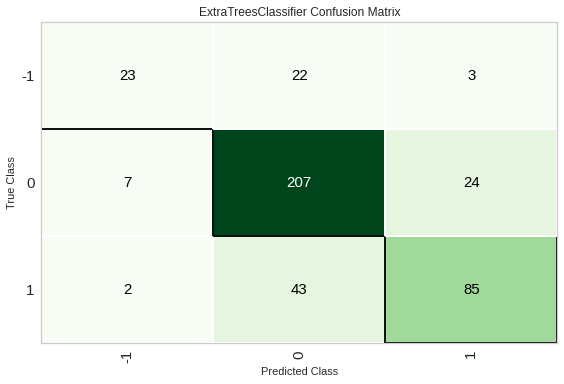

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() successfully completed......................................


In [ ]:
plot_model(et_model, plot='confusion_matrix')

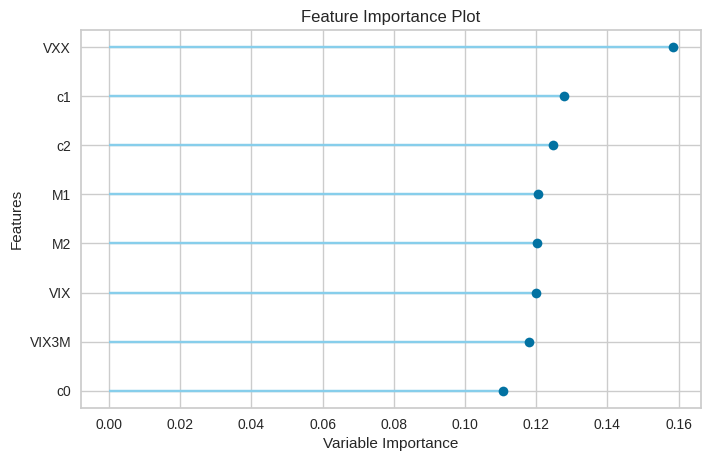

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() successfully completed......................................


In [ ]:
plot_model(et_model,plot='feature')

In [ ]:
predictions = predict_model(et_model, data=test_data)
predictions, test_data_0

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(n_jobs=-1, random_state=345), probability_threshold=None, encoded_labels=False, raw_score=False, drift_report=False, round=4, verbose=True, ml_usecase=None, display=None, replace_labels_in_column=<function _SupervisedExperiment.predict_model.<locals>.replace_labels_in_column at 0x7f6c70315c20>, self=<pycaret.classification.oop.ClassificationExperiment object at 0x7f6c70486c10>)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


(       VIX     M1     M2  VIX3M    VXX        c0        c1        c2  Label  \
 0    14.99  18.25  19.15  18.48  20.10  0.217478  0.049315 -0.034987      0   
 1    15.42  16.80  18.45  18.38  18.58  0.089494  0.098214 -0.003794      0   
 2    16.16  17.27  18.88  18.86  18.95  0.068688  0.093225 -0.001059      0   
 3    16.26  17.10  19.00  18.87  18.76  0.051661  0.111111 -0.006842      0   
 4    13.95  16.80  18.45  17.14  16.40  0.204301  0.098214 -0.071003      0   
 ..     ...    ...    ...    ...    ...       ...       ...       ...    ...   
 149  23.87  27.15  27.45  26.55  25.00  0.137411  0.011050 -0.032787      0   
 150  23.57  25.20  26.00  26.41  25.49  0.069156  0.031746  0.015769      1   
 151  21.67  24.28  25.45  25.30  25.20  0.120443  0.048188 -0.005894      1   
 152  19.33  22.00  24.00  23.57  25.00  0.138127  0.090909 -0.017917      1   
 153  22.10  23.95  25.53  25.80  24.38  0.083710  0.065971  0.010576      1   
 
      Score  
 0     0.03  
 1     0.0

In [ ]:
save_model(et_model,'vix_trading_signal')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=ExtraTreesClassifier(n_jobs=-1, random_state=345), model_name=vix_trading_signal, prep_pipe_=Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransfomerWrapper(include=['VIX', 'M1', 'M2', 'VIX3M', 'VXX', 'c0', 'c1', 'c2'], transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransfomerWrapper(include=[], transformer=SimpleImputer(fill_value='constant', strategy='constant')))]), verbose=True, use_case=MLUsecase.CLASSIFICATION, kwargs={})
INFO:logs:Adding model into prep_pipe
INFO:logs:vix_trading_signal.pkl saved in current working directory
INFO:logs:Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransfomerWrapper(include=['VIX', 'M1', 'M2', 'VIX3M', 'VXX', 'c0', 'c1', 'c2'], transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransfomerWrapper(inclu

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransfomerWrapper(include=['VIX', 'M1', 'M2', 'VIX3M', 'VXX', 'c0', 'c1', 'c2'], transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransfomerWrapper(include=[], transformer=SimpleImputer(fill_value='constant', strategy='constant'))),
                 ['trained_model',
                  ExtraTreesClassifier(n_jobs=-1, random_state=345)]]),
 'vix_trading_signal.pkl')

In [ ]:
#backtesting
#the performance portfolio following trading signals 
